In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from pprint import pprint
from math import ceil
import imodelsx.util
import sasc.viz
from copy import deepcopy
from sklearn.cluster import AgglomerativeClustering
from PIL import Image
from scipy.sparse import csr_matrix
from sasc.config import CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir, FMRI_DIR, SAVE_DIR_FMRI
import sasc.modules.fmri_module
from neuro.config import repo_dir, PROCESSED_DIR
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gemv
from neuro.flatmaps_helper import load_flatmaps

subject = 'S02'
k_values = np.unique(np.logspace(0.5, 3.5, 20, dtype=int))
SUBJECT_VOX_COUNTS_DICT = {'S02': 94251,}

# load connectivity stuff
data = np.load(
    join(FMRI_DIR, 'brain_tune/voxel_neighbors_and_pcs/', 'connectivity.npz'))
connectivity = csr_matrix(
    (data['data'], data['indices'], data['indptr']), shape=data['shape'])

# q = 'Does the input contain a number?'
q = 'Does the input contain a measurement?'

In [ ]:
# flatmaps qa dict
settings = ['individual_gpt4', 'individual_gpt4_wordrate', 'shapley_35']
flatmaps_qa_list = defaultdict(list)
for setting in settings:
    flatmaps_qa_dict = joblib.load(
        join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
    for q in flatmaps_qa_dict.keys():
        flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
flatmaps_qa_dict = {
    q: np.mean(flatmaps_qa_list[q], axis=0)
    for q in flatmaps_qa_list.keys()}

### Run clustering

In [ ]:
for q in tqdm(gemv.QS_35_SORTED_BEST_TO_WORST[:35]):
    out_dir = join(cache_ngrams_dir, 'clusters', q)
    os.makedirs(out_dir, exist_ok=True)
    flatmap_q = flatmaps_qa_dict[q].reshape(-1, 1)
    cluster_assignments_dict = {}
    for num_clusters in tqdm(k_values):
        out_fname = f'clusters/cluster_aggregated_{num_clusters}.png'
        out_fname_pkl = join(
            out_dir, f'cluster_assignments_dict_{subject}.jbl')
        if not os.path.exists(out_fname_pkl):
            clustering = AgglomerativeClustering(
                n_clusters=num_clusters,
                connectivity=connectivity,
                linkage='ward',
            )

            clustering.fit(flatmap_q)
            cluster_assignments = clustering.labels_
            cluster_assignments_dict[num_clusters] = deepcopy(
                cluster_assignments)

            # visualize clusters
            # for i in range(min(20, num_clusters)):
            #     flatmap = (cluster_assignments == i).astype(int)

            #     sasc.viz._save_flatmap(
            #         flatmap, 'S02', fname_save=f'clusters/{i+1}.png')

            # # # read all plots and save as subplots on the same page
            # C = 10
            # R = ceil(min(20, num_clusters)/C)
            # fig, axs = plt.subplots(R, C, figsize=(C * 4, R * 2))
            # axs = axs.ravel()
            # for i in range(min(20, num_clusters)):
            #     axs[i].imshow(Image.open(f'clusters/{i+1}.png'))
            #     axs[i].axis('off')
            #     axs[i].set_title(f'{i + 1}')
            # plt.savefig(out_fname)
            joblib.dump(cluster_assignments_dict, out_fname_pkl)

    # sasc.viz._save_flatmap(
    #     flatmap_q.flatten(), 'S02', fname_save=f'clusters/raw_data.png')

### Evaluate clustering

In [79]:
def get_cluster_data(cluster_assignments_dict, flatmap_q, q, i_cluster, topk):
    # load clusters
    out_dir = join(cache_ngrams_dir, 'clusters', q)
    cluster_assignments_dict = joblib.load(join(
        out_dir, f'cluster_assignments_dict_{subject}.jbl'))
    r = defaultdict(list)
    for k in cluster_assignments_dict.keys():
        clusters = cluster_assignments_dict[k]
        cluster_sizes = np.unique(clusters, return_counts=True)[1]
        cluster_vals = np.array([
            np.median(flatmap_q[clusters == i]) for i in range(k)])
        r['num_clusters'].append(k)
        r['cluster_sizes'].append(cluster_sizes)
        r['cluster_driving_scores'].append(cluster_vals)
    r = pd.DataFrame(r)
    row = r.iloc[i_cluster]

    # look at clusters
    # plt.plot(row['cluster_sizes'], row['cluster_driving_scores'], '.')
    # plt.grid()
    # plt.xscale('log')
    # plt.xlabel('Cluster size')
    # plt.ylabel('Cluster driving score')
    # plt.show()

    # get good_cluster_idxs with size > 10 and top 5 driving scores
    good_clusters = (row['cluster_sizes'] > 10)
    good_cluster_idxs = np.arange(len(row['cluster_sizes']))[good_clusters]
    good_cluster_idxs = good_cluster_idxs[np.argsort(
        -row['cluster_driving_scores'][good_clusters])[:topk]]

    k_cluster = row['num_clusters']
    num_clusters = len(good_cluster_idxs)
    cluster_assignments = cluster_assignments_dict[k_cluster]

    # for i in tqdm(range(min(20, num_clusters))):
    #     k = good_cluster_idxs[i]
    #     flatmap = (cluster_assignments == k).astype(int)

    #     sasc.viz._save_flatmap(
    #         flatmap, 'S02', fname_save=f'good_clusters/{i+1}.png')

    # # read all plots and save as subplots on the same page
    # C = 10
    # R = ceil(min(20, num_clusters)/C)
    # fig, axs = plt.subplots(R, C, figsize=(C * 4, R * 2))
    # axs = axs.ravel()
    # for i in range(min(20, num_clusters)):
    #     axs[i].imshow(Image.open(f'good_clusters/{i+1}.png'))
    #     axs[i].axis('off')
    #     axs[i].set_title(f'{i + 1}')
    # plt.savefig('good_clusters/cluster_aggregated.png')
    return cluster_assignments, good_cluster_idxs, row['cluster_sizes']


def evaluate_gemv_driving_scores(cluster_assignments, good_cluster_idxs, cluster_sizes, flatmap_q, q):

    # load gemv flatmaps
    gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03, gemv_flatmaps_dict_S02_timecourse, gemv_flatmaps_dict_S03_timecourse = load_flatmaps(
        normalize_flatmaps=False, load_timecourse=True)
    gemv_flatmaps_dict = gemv_flatmaps_dict_S02

    # gemv_flatmaps_dict = gemv_flatmaps_pilot | gemv_flatmaps_pilot5
    qa_questions_list, gemv_questions_list = gemv.get_matched_lists()
    qa_to_gemv_questions_list = {
        qa_q: gemv_q
        for gemv_q, qa_q in zip(gemv_questions_list, qa_questions_list)
    }
    q_gemv = qa_to_gemv_questions_list[q]
    flatmap_gemv = gemv_flatmaps_dict[q_gemv]

    # evaluate cluster driving scores
    driving_scores = []
    qa_driving_scores = []
    for k in good_cluster_idxs:
        cluster_driving_score = np.nanmean(
            flatmap_gemv[cluster_assignments == k])
        driving_scores.append(cluster_driving_score)
        qa_driving_score = np.nanmean(flatmap_q[cluster_assignments == k])
        qa_driving_scores.append(qa_driving_score)
    # plt.hist(driving_scores)
    # print('mean gemv driving score', np.nanmean(driving_scores))
    # df = pd.DataFrame({
    #     'qa_driving_scores': qa_driving_scores,
    #     'driving_scores': driving_scores,
    #     'cluster_size': cluster_sizes[good_cluster_idxs],
    # })
    # plt.plot(qa_driving_scores, driving_scores, '.')
    # plt.xlabel('QA driving score')
    # plt.ylabel('GEMV driving score')
    # sns.scatterplot(data=df, x='qa_driving_scores',
    #                 y='driving_scores', hue='cluster_size')
    # plt.axhline(0, color='k', linestyle='--')
    # plt.axhline(np.mean(driving_scores), color='pink', linestyle='--')
    # plt.show()

    # t-test on cluster driving score

    def _zscore_to_pvalue_right_tailed(z):
        """Return the right-tailed p-value for a given z-score."""
        return 1 - norm.cdf(z)

    driving_scores = []
    zscores = []
    pvals = []
    for k in good_cluster_idxs:
        cluster_mask = cluster_assignments == k
        timecourse_roi = gemv_flatmaps_dict_S02_timecourse[q_gemv][cluster_mask]
        flatmap_gemv = gemv_flatmaps_dict[q_gemv]

        driving_score = np.mean(flatmap_gemv[cluster_mask])
        stderr = timecourse_roi.mean(
            axis=0).std() / np.sqrt(timecourse_roi.shape[1])
        zscore = driving_score / stderr
        pval = _zscore_to_pvalue_right_tailed(zscore)

        driving_scores.append(driving_score)
        zscores.append(zscore)
        pvals.append(pval)
    return driving_scores, pvals

In [127]:
i_cluster = 14  # which num clusters to use
topk = 5
d = defaultdict(list)
for i in tqdm(range(10)):
    q = gemv.QS_35_SORTED_BEST_TO_WORST[i]

    cluster_assignments, good_cluster_idxs, cluster_sizes = get_cluster_data(
        cluster_assignments_dict, flatmap_q, q, i_cluster, topk)

    driving_scores, pvals = evaluate_gemv_driving_scores(
        cluster_assignments, good_cluster_idxs, cluster_sizes, flatmap_q, q)

    d['q'].append(q)
    d['q_idx'].append(i)
    d['scores'].append(list(zip(driving_scores, pvals)))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


mean 0.06684942987955501 frac sig 0.46


<>:16: DeprecationWarning: invalid escape sequence '\s'
<>:16: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_872657/34820922.py:16: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel('Driving score ($\sigma$)')


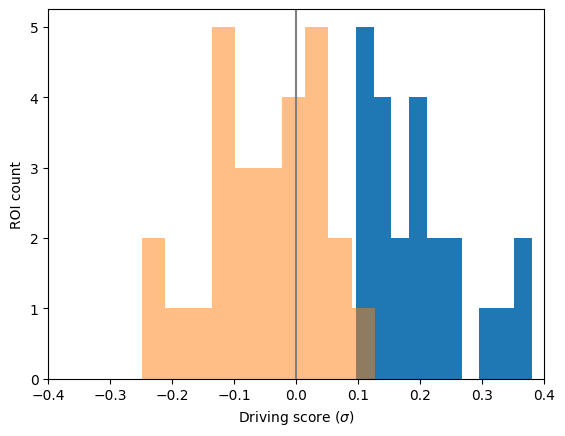

In [131]:
df = pd.DataFrame(d).explode('scores')

# split scores into two columns
df['driving_score'] = df['scores'].apply(lambda x: x[0])
df['pval'] = df['scores'].apply(lambda x: x[1]).round(4)
df['pval_sig'] = df['pval'] <= 0.05
df = df.drop(columns='scores')

plt.hist(df['driving_score'].values[df['pval_sig']])
plt.hist(df['driving_score'].values[~df['pval_sig']], alpha=0.5)
# plt.hist(df['driving_score'].values)
plt.xlim(-0.4, 0.4)
print('mean', df['driving_score'].mean(), 'frac sig', df['pval_sig'].mean())
plt.axvline(0, color='gray', linestyle='-')
# plt.axvline(df['driving_score'].mean(), color='red', linestyle='--')
plt.xlabel('Driving score ($\sigma$)')
plt.ylabel('ROI count')
plt.show()

In [ ]:
# top 10 qs
# 18 -- mean 0.0657457187708968 frac sig 0.32
# 16 -- mean 0.055758184636718326 frac sig 0.36
# 14 -- mean 0.06684942987955501 frac sig 0.46
# 12 -- mean 0.05949818369837145 frac sig 0.48